In [60]:
## Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

## Explanatory Analysis

In [61]:
wine_pd = pd.read_csv('winemag-data-130k-v2.csv')

In [62]:
wine_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [63]:
wine_pd.describe(include='object')

,country,description,designation,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129908,129971,92506,129908,108724,50511,103727,98758,129971,129970,129971
unique,43,119955,37979,425,1229,17,19,15,118840,707,16757
top,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,54504,3,2009,36247,4480,11065,25514,25514,11,13272,222


In [64]:
wine_pd.describe(include=[np.number])

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [65]:
# Split the data into train and test
train_df, test_df = train_test_split(wine_pd, test_size=0.2, random_state=42)


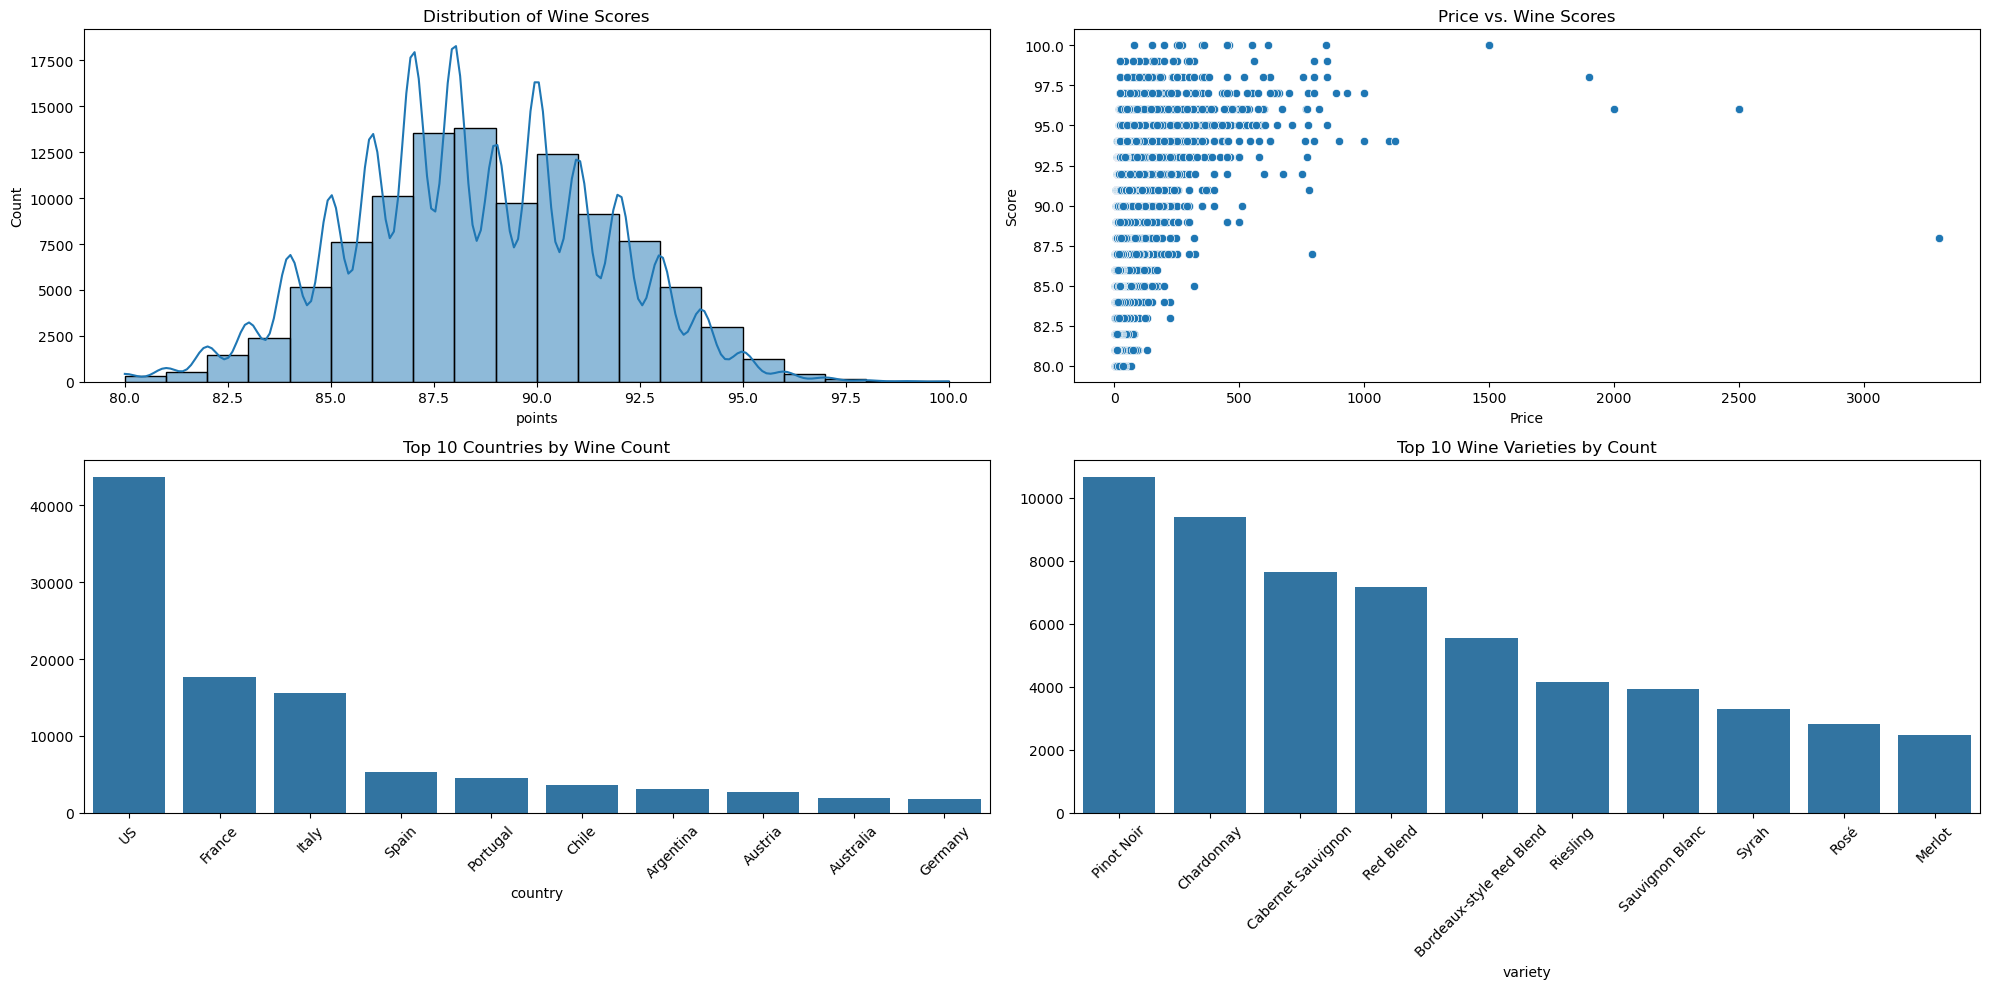

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the Description Set and its corresponding target set
X_train_d = train_df['description']
X_test_d = test_df['description']


# Drop the unnecessary columns and create the major features X and target y

X_train = train_df.drop(columns=['points'])
X_test = test_df.drop(columns=['points'])
# Create the target set
y_train = train_df['points']
y_test = test_df['points']

X_train.head()
X_train.describe(include='object')

# Setting up the visualizations
plt.figure(figsize=(20, 10))

# Distribution of the target variable (wine scores)
plt.subplot(2, 2, 1)
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Wine Scores')

# Relationship between price and points in the training set
# Note: We'll need to handle missing values in 'price' for plotting
plt.subplot(2, 2, 2)
sns.scatterplot(x=X_train['price'].fillna(X_train['price'].median()), y=y_train)
plt.title('Price vs. Wine Scores')
plt.xlabel('Price')
plt.ylabel('Score')

# Distribution of wines by country
plt.subplot(2, 2, 3)
country_counts = X_train['country'].value_counts().head(10)  # Top 10 countries
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Top 10 Countries by Wine Count')
plt.xticks(rotation=45)

# Distribution of wines by variety
plt.subplot(2, 2, 4)
variety_counts = X_train['variety'].value_counts().head(10)  # Top 10 varieties
sns.barplot(x=variety_counts.index, y=variety_counts.values)
plt.title('Top 10 Wine Varieties by Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We noticed that the points distribution is likely to be normal, with an average close to 88, thus we chose 88 as it marks the top 50% percent of wines, which we regard as premium wines.

### Feature Selection After EDA

In [67]:
# discretize the points into 2 categories: 0 for points <= threshold and 1 for points > threshold(considered as premium wine)
threshold = 88
train_df['points'] = train_df['points'].apply(lambda x: 1 if x > threshold else 0)
test_df['points'] = test_df['points'].apply(lambda x: 1 if x > threshold else 0)

# Create the Description Set and its corresponding target set
X_train_d = train_df['description']
X_test_d = test_df['description']


# Drop the unnecessary columns and create the major features X and target y

X_train = train_df.drop(columns=['points', 'description', 'taster_name', 'taster_twitter_handle', 'title', 'region_2', 'Unnamed: 0','price','designation'])
X_test = test_df.drop(columns=['points', 'description', 'taster_name', 'taster_twitter_handle', 'title', 'region_2', 'Unnamed: 0','price','designation'])
# Create the target set
y_train = train_df['points']
y_test = test_df['points']

X_train.head()
X_train.describe(include='object')

,country,province,region_1,variety,winery
count,103924,103924,86980,103975,103976
unique,43,413,1196,668,15807
top,US,California,Napa Valley,Pinot Noir,Testarossa
freq,43677,29099,3599,10658,176


In [68]:
X_train.describe(include="object")

,country,province,region_1,variety,winery
count,103924,103924,86980,103975,103976
unique,43,413,1196,668,15807
top,US,California,Napa Valley,Pinot Noir,Testarossa
freq,43677,29099,3599,10658,176


In [69]:
[y_train.value_counts() ,y_test.value_counts()]

[points
 0    55003
 1    48973
 Name: count, dtype: int64,
 points
 0    13697
 1    12298
 Name: count, dtype: int64]

## Feature Preprocessing

### Major Features Preprocessing Pipeline

In [70]:
from sklearn.compose import ColumnTransformer

In [71]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

categorical_features

['country', 'province', 'region_1', 'variety', 'winery']

In [72]:
# numeric_transformer = Pipeline([('scaler', StandardScaler()),('imputer', SimpleImputer(strategy='most_frequent'))])

# Define the categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent", fill_value="missing")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the column transformer
col_transformer = ColumnTransformer([
    # ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])



## Hyparameter Tuning and Model Selection

### Models for Major Features

#### Dummy Classifier

In [73]:
# dummyclassifier

dummy = Pipeline([
    ('columntransformer', col_transformer),
    ('classifier', DummyClassifier(strategy='stratified'))
])

dummy.fit(X_train, y_train)

dummy_score = dummy.score(X_test, y_test)

dummy_report =  classification_report(y_test, dummy.predict(X_test))

#### Decision Tree

In [74]:
# Create the main pipeline with SVC
main_pipe = Pipeline([
    ('columntransformer', col_transformer),
    ('classifier', DecisionTreeClassifier())
])

main_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'province',
                                                   'region_1', 'variety',
                                                   'winery'])])),
                ('classifier', DecisionTreeClassifier())])

In [75]:
param_grid = {
    'classifier__max_depth': randint(1, 100),
    'classifier__min_samples_split': randint(2, 100),
    'classifier__min_samples_leaf': randint(1, 100),
    'classifier__criterion': ['gini', 'entropy'] 
}

In [76]:
major_random_search = RandomizedSearchCV(main_pipe, param_grid, n_iter=20, cv=3, verbose=1, n_jobs=-1, random_state=289, return_train_score=True, error_score='raise')
major_random_search.fit(X_train, y_train)
print(major_random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'classifier__criterion': 'gini', 'classifier__max_depth': 85, 'classifier__min_samples_leaf': 12, 'classifier__min_samples_split': 8}


In [77]:

dt_score = major_random_search.score(X_test, y_test)
# print("Test set score:", test_score)


y_pred = major_random_search.predict(X_test)
dt_report = classification_report(y_test, y_pred)
# print(report)


#### Random Forest

In [78]:
# Create the main pipeline with random forest
r_forest_pipe = Pipeline([
    ('columntransformer', col_transformer),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': randint(1, 100),
    'classifier__max_depth': randint(1, 100),
    'classifier__min_samples_split': randint(2, 100),
    'classifier__min_samples_leaf': randint(1, 100),
    'classifier__criterion': ['gini', 'entropy'] 
}

r_forest_random_search = RandomizedSearchCV(r_forest_pipe, param_grid, n_iter=20, cv=3, verbose=1, n_jobs=-1, random_state=289, return_train_score=True)

r_forest_random_search.fit(X_train, y_train)

print("Best parameters set:")
print(r_forest_random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters set:
{'classifier__criterion': 'gini', 'classifier__max_depth': 85, 'classifier__min_samples_leaf': 12, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 34}


In [79]:
rf_score = r_forest_random_search.score(X_test, y_test)
# print("Test set score:", test_score)
y_pred = r_forest_random_search.predict(X_test)
rf_report = classification_report(y_test, y_pred)
# print(report)

In [80]:
perm_importance = permutation_importance(r_forest_random_search, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
importance_scores = perm_importance.importances_mean

# Combine feature names and importance scores
feature_importances = list(zip(feature_names, importance_scores))

# Sort the feature importances in descending order
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

region_1: 0.049019683272424154
variety: 0.027961787523241622
province: 0.014648970955953038
country: 0.010073732127973294
winery: 0.008211835609412025


#### Logistic

In [81]:
# create a pipeline with logistic regression
logistic_pipe = Pipeline([
    ('columntransformer', col_transformer),
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__C': loguniform(0.01, 10),
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': randint(100, 1000)
}

logistic_random_search = RandomizedSearchCV(logistic_pipe, param_grid, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=289, return_train_score=True)

logistic_random_search.fit(X_train, y_train)
print("Best parameters set:")
print(logistic_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters set:
{'classifier__C': 3.4393145155916303, 'classifier__max_iter': 332, 'classifier__solver': 'newton-cg'}


In [82]:
log_score = logistic_random_search.score(X_test, y_test)
# print("Test set score:", test_score)
y_pred = logistic_random_search.predict(X_test)
log_report = classification_report(y_test, y_pred)
# print(report)

### Models for Descriptions

#### Dummy Classifier

In [83]:
dummy_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', DummyClassifier(strategy='stratified'))
])


dummy_pipeline.fit(X_train_d, y_train)

dummy_d_score = dummy_pipeline.score(X_test_d, y_test)
# print()
dummy_d_report = classification_report(y_test, dummy_pipeline.predict(X_test_d))
# print()

#### Naive Bayes

In [84]:
nb_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Define the parameter space for the random search
nb_parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__max_features': randint(10000,30000),  # number of features to consider
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__alpha': np.linspace(0.1, 2, 20),  # smoothing parameter
}

# Set up the random search with cross-validation
nb_random_search = RandomizedSearchCV(nb_pipeline, nb_parameters, n_iter=10, cv=5, random_state=42,verbose=1,return_train_score=True, n_jobs=-1)

# Execute the random search
nb_random_search.fit(X_train_d, y_train)

# Output the best parameters
print("Best parameters set:")
print(nb_random_search.best_params_)




Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters set:
{'clf__alpha': 1.7, 'vect__max_df': 1.0, 'vect__max_features': 28942, 'vect__ngram_range': (1, 2)}


In [85]:

# Output the test score
nb_d_score = nb_random_search.score(X_test_d, y_test)
# print("Test set score:", nb_d_accuracy)
nb_d_report = classification_report(y_test, nb_random_search.predict(X_test_d))
# print(classification_report(y_test, nb_random_search.predict(X_test_d)))

#### Logistic Regression

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, classification_report

# Set up the pipeline
logistic_d_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Define the parameter distribution
param_distributions = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_df': loguniform(0.7, 1.0),
    'tfidf__min_df': [1, 2, 5],
    'logreg__C': loguniform(1e-5, 100)
}

# Set up RandomizedSearchCV
log_random_search = RandomizedSearchCV(logistic_d_pipeline, param_distributions=param_distributions, n_iter=10, cv=5, verbose=1, return_train_score=True, n_jobs=-1, random_state=42)

# Fit the model
log_random_search.fit(X_train_d, y_train)

# Best parameters found
print("Best parameters:", log_random_search.best_params_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'logreg__C': 0.19185373703841915, 'tfidf__max_df': 0.7357087350422706, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [87]:

# Optionally, predict and evaluate the model
y_pred = log_random_search.predict(X_test_d)
log_d_score = log_random_search.score(X_test_d, y_test)
# print(f'Accuracy: {log_d_score:.4f}')
log_d_report = classification_report(y_test, y_pred)
# print(classification_report(y_test, y_pred))

#### Random Forest

In [88]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


# Define the pipeline
pipeline = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    # 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # 'tfidf__max_df': [0.5, 0.75, 1.0],
    # 'tfidf__min_df': [1, 2, 5],
    'cvec__ngram_range': [(1, 2), (1, 3)],  # unigrams or bigrams or trigrams
    'cvec__max_features': randint(10000, 30000),
    'cvec__max_df': (0.5, 0.75, 1.0),
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': randint(3, 20),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 11)
}

# Set up R
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, 
                                   n_iter=20, cv=3, verbose=1, n_jobs=-1, random_state=42, return_train_score=True)

# Fit the model
random_search.fit(X_train_d, y_train)

# Best parameters found
print("Best parameters:", random_search.best_params_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zhanmingxiao/miniconda3/envs/509/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'clf__max_depth': 18, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__n_estimators': 343, 'cvec__max_df': 0.5, 'cvec__max_features': 21394, 'cvec__ngram_range': (1, 2)}


In [89]:
# Optionally, predict and evaluate the model
y_pred = random_search.predict(X_test_d)
# Evaluate the predictions, e.g., using accuracy_score, confusion_matrix
# Calculate accuracy
rf_d_score = random_search.score(X_test_d, y_test)
rf_d_report = classification_report(y_test, y_pred)
# print("Accuracy:", accuracy)



## Reflection on selected performance metrics

In [90]:
import pandas as pd

# Create dictionaries to store the scores and reports
scores = {
    'Dummy Classifier': dummy_score,
    'Decision Tree': dt_score,
    'Random Forest': rf_score,
    'Logistic Regression': log_score
}

reports = {
    'Dummy Classifier': dummy_report,
    'Decision Tree': dt_report,
    'Random Forest': rf_report,
    'Logistic Regression': log_report
}

# Print the scores and reports
for model, score in scores.items():
    print(f"{model} Score: {score}")

for model, report in reports.items():
    print(f"{model} Report:\n{report}")


Dummy Classifier Score: 0.49890363531448356
Decision Tree Score: 0.6887863050586651
Random Forest Score: 0.6667436045393345
Logistic Regression Score: 0.7520677053279476
Dummy Classifier Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     13697
           1       0.48      0.48      0.48     12298

    accuracy                           0.51     25995
   macro avg       0.50      0.50      0.50     25995
weighted avg       0.51      0.51      0.51     25995

Decision Tree Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.72     13697
           1       0.70      0.59      0.64     12298

    accuracy                           0.69     25995
   macro avg       0.69      0.68      0.68     25995
weighted avg       0.69      0.69      0.69     25995

Random Forest Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71     1369

In [91]:

# Scores and reports from the Models for Descriptions part
scores = {
    'Dummy Classifier': dummy_d_score,
    'Naive Bayes': nb_d_score,
    'Logistic Regression': log_d_score,
    'Random Forest': rf_d_score
}

reports = {
    'Dummy Classifier': dummy_d_report,
    'Naive Bayes': nb_d_report,
    'Logistic Regression': log_d_report,
    'Random Forest': rf_d_report
}

# Print the scores
print("Scores:")
for model, score in scores.items():
    print(f"{model}: {score}")

# Print the reports
print("\nReports:")
for model, report in reports.items():
    print(f"{model}:\n{report}")


Scores:
Dummy Classifier: 0.5084439315252933
Naive Bayes: 0.8050009617234083
Logistic Regression: 0.82488940180804
Random Forest: 0.7457587997691864

Reports:
Dummy Classifier:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     13697
           1       0.47      0.47      0.47     12298

    accuracy                           0.50     25995
   macro avg       0.50      0.50      0.50     25995
weighted avg       0.50      0.50      0.50     25995

Naive Bayes:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82     13697
           1       0.80      0.79      0.79     12298

    accuracy                           0.81     25995
   macro avg       0.80      0.80      0.80     25995
weighted avg       0.80      0.81      0.80     25995

Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     13697
           1       0.82   

### Major Features Classification Models
- Accuracy: Logistic Regression achieves the highest accuracy of 0.7521 among all models tested, indicating it correctly predicts wine quality more often than the other models.

- Balance between Precision and Recall: The Logistic Regression model shows a strong balance between precision and recall for both classes (0 and 1), with precision values of 0.76 and 0.74, and recall values of 0.77 and 0.73, respectively. This balance is crucial in scenarios where both false positives and false negatives are of concern.

- F1-Score: The f1-scores for Logistic Regression are the highest among the models for both classes, indicating a robust balance between precision and recall. This suggests that Logistic Regression not only makes accurate predictions but does so in a balanced manner across both classes.

- Comparative Performance: When compared to the other models, Logistic Regression consistently outperforms the Decision Tree, Random Forest, and certainly the Dummy Classifier across all key metrics (accuracy, precision, recall, f1-score). The Decision Tree and Random Forest models show decent performance but are not as balanced or as high performing as Logistic Regression.

Given these points, the Logistic Regression model is the best choice for predicting wine quality based on the dataset provided. It offers the highest accuracy and the best balance between identifying positive cases and minimizing false positives, making it the most reliable model among those tested for this specific task.

### Description Classification Models

- Highest Accuracy: Logistic Regression has the highest accuracy score, indicating it makes the most correct predictions for wine quality out of all models tested.

- Balanced Precision and Recall: It offers a balanced performance between precision and recall for both classes, with precision at 0.83 for class 0 and 0.82 for class 1, alongside recall at 0.84 for class 0 and 0.81 for class 1. This balance is crucial for making reliable predictions in both classes without bias toward predicting one class more accurately than the other.

- Strong F1-Score: The F1-scores, which are the harmonic mean of precision and recall, are also highest for the Logistic Regression model, indicating a strong balance between the precision and recall across both classes. This suggests that Logistic Regression not only accurately identifies positive cases but does so with a minimal number of false positives and negatives.

- Comparatively, while Naive Bayes shows commendable performance with an accuracy of 0.8050, it slightly lags behind Logistic Regression in both accuracy and the balance of precision and recall across classes. Random Forest has a lower accuracy of 0.7458 and demonstrates a significant imbalance between precision and recall, especially for class 1, indicating a tendency to misclassify a higher proportion of actual positives compared to Logistic Regression and Naive Bayes.

- The Dummy Classifier is intended as a baseline with an accuracy close to random guessing, as expected, and is significantly outperformed by the other models.

Given these insights, Logistic Regression is the most suitable model for predicting wine quality in this context due to its superior accuracy, balanced precision and recall, and strong F1-scores, making it the most reliable and balanced model among those evaluated.

## Results Interpretation

### Feature Importance

In [92]:
perm_importance = permutation_importance(logistic_random_search, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
importance_scores = perm_importance.importances_mean

# Combine feature names and importance scores
feature_importances = list(zip(feature_names, importance_scores))

# Sort the feature importances in descending order
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

winery: 0.11987305251009804
province: 0.08408924793229462
region_1: 0.06850932871706096
country: 0.06850676412130532
variety: 0.023585304866320416


- winery: The most important feature, with a score of approximately 0.1199, indicating that the winery where the wine is produced has the highest impact on the wine quality prediction.
- province: The second most important feature, with a score of about 0.0841, suggesting the province of the winery also significantly affects the wine quality prediction.
- region_1 and country: These features have nearly identical importance scores (around 0.0685), indicating they both meaningfully contribute to predicting wine quality, with the specific region within a country and the country itself being almost equally important.
- variety: The least important of the listed features but still relevant, with a score of approximately 0.0236, showing that the type of grape used in the wine has a smaller yet non-negligible effect on the quality prediction.

### Description Keywords

In [93]:
best_estimator =  log_random_search.best_estimator_

coef_df = pd.DataFrame({
    'words': best_estimator[ "tfidf"].get_feature_names_out(),
    'coefficient': best_estimator["logreg"].coef_[0]
})

positive_words = coef_df.sort_values('coefficient', ascending=False).head(50)['words']
positive_words

16988         complex
43563            long
81709           years
20244       delicious
500              2020
23867         elegant
60042            rich
38004      impressive
77748        vineyard
43927          lovely
7035        beautiful
521              2022
7079      beautifully
17306    concentrated
536              2025
34819           great
516              2021
24965       excellent
77372         velvety
56737        powerful
57856            pure
22021      drink 2020
26481            fine
464              2018
482              2019
51812         opulent
527              2023
44149            lush
19944            deep
6326         balanced
46399      minerality
29765         focused
12815          cellar
40446         layered
34237        gorgeous
60481        richness
22023      drink 2022
23812        elegance
69592      structured
59219         refined
22022      drink 2021
20828           depth
38476         intense
2634              age
56327        polished
533       

### Business Insights From the Models

### **Major Features**

Utilizing the output from the permutation importance analysis in the context of designing premium wines involves focusing on the features that have the most significant impact on wine quality as identified by the logistic regression model.

### 1. Leverage the Winery's Reputation
- **Focus on Branding**: With "winery" having the highest importance score, the reputation and branding of the winery are crucial. Develop a strong brand story that emphasizes quality, craftsmanship, and the unique aspects of your winery that contribute to producing premium wines.
- **Quality Consistency**: Ensure that the winery maintains high standards in wine production to strengthen and uphold its reputation as a marker of premium quality.

### 2. Highlight the Geography
- **Province and Region**: The importance of "province" and "region_1" suggests that the geographic origin of the wine significantly affects its perceived quality. Highlight the unique characteristics of the province and region in your marketing, focusing on terroir, climate, and how these factors contribute to the distinctive qualities of your wines.
- **Country of Origin**: With "country" also being a significant factor, leverage the country's image in the wine market. For example, certain countries are renowned for their wine quality and specific varieties. Use this to your advantage in storytelling and branding.

### **Description Keywords**

The output description mining model identifies keywords highly associated with the score of wines, provides valuable insights into the characteristics that are often mentioned in descriptions of higher-quality (premium) wines. To apply these keywords in designing premium wines, we may use the following strategies:

### 1. Focus on Quality and Complexity
- **Complexity and Depth**: Terms like "complex," "layered," "depth," and "complexity" suggest that premium wines are appreciated for their multifaceted flavors and aromas. Aim to develop wines that offer a rich array of sensory experiences.
- **Balance and Structure**: Keywords such as "balanced" and "structured" indicate the importance of a harmonious blend of acidity, tannins, sweetness, and alcohol. Ensure your winemaking process focuses on achieving a well-rounded wine.

### 2. Aim for Desirable Taste Profiles and Aromas
- **Richness and Opulence**: Descriptors like "rich," "opulent," "lush," and "velvety" point to a preference for wines with a full-bodied feel and luxurious taste. Consider grape varieties and fermentation processes that enhance these attributes.
- **Elegance and Refinement**: Words such as "elegant," "refined," "polished," and "lovely" suggest a market appreciation for wines that are sophisticated and gracefully composed. Strive for subtlety and finesse in flavor profiles.

### 3. Highlight Specific Vintage and Aging Potential
- **Vintage and Drinkability**: The presence of specific years (e.g., 2020, 2021, 2022) and phrases like "drink 2020" imply the importance of vintage quality and optimal drinking windows. Highlight the best vintages and advise on aging potential to guide consumers.
- **Aging and Cellaring**: "Years," "cellar," "aged," and future years (e.g., 2025) suggest consumers value wines that age well. Focus on producing wines that will develop positively over time, offering guidance on cellaring practices.

### 4. Emphasize Terroir and Winemaking Excellence
- **Vineyard and Terroir**: "Vineyard," "minerality," and "terroir-focused" indicate the value placed on the origin and unique characteristics imparted by specific locations. Promote the unique aspects of your vineyard's terroir in your wine's branding.
- **Winemaking Techniques**: Use of "barrel sample" and specific tasting notes (e.g., "minerality," "elegance") can reflect the winemaking process's influence on the wine's character. Adopt and highlight winemaking techniques that contribute to the desired profiles.

### 5. Marketing and Labeling
- **Descriptive Marketing**: Incorporate these keywords into your wine labels, marketing materials, and tasting notes. Describing your wine using terms found to be associated with higher scores can attract consumers looking for premium wine experiences.
- **Storytelling**: Build narratives around your wines that include these descriptors, focusing on the craftsmanship, vineyard heritage, and the sensory journey the wine offers.

